# Meshing ETOPO1

In this notebook we:

1. Find the land surface in a region by filtering ETOPO1 
2. Optionally correct for the geoid (important in low-gradient / low-lying areas)
4. Create a DM object and refine a few times
5. Save the mesh to HDF5 file

In [1]:
from osgeo import gdal

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import quagmire
from quagmire import tools as meshtools

from scipy.ndimage import imread
from scipy.ndimage.filters import gaussian_filter
from matplotlib.colors import LightSource

## 1. Import coastline shapefile

This requires pyshp to be installed. We scale the points to match the dimensions of the DEM we'll use later.

In [2]:
# def remove_duplicates(a):
#     """
#     find unique rows in numpy array 
#     <http://stackoverflow.com/questions/16970982/find-unique-rows-in-numpy-array>
#     """
#     b = np.ascontiguousarray(a).view(np.dtype((np.void, a.dtype.itemsize * a.shape[1])))
#     dedup = np.unique(b).view(a.dtype).reshape(-1, a.shape[1])
#     return dedup

# coast_shape = shapefile.Reader("data/AustCoast/AustCoast2.shp")
# shapeRecs = coast_shape.shapeRecords()
# coords = []
# for record in shapeRecs:
#     coords.append(record.shape.points[:])
    
# coords = np.vstack(coords)

# # Remove duplicates
# points = remove_duplicates(coords)

In [3]:
## Define region of interest (here NZ)

bounds = (165.0, -48.5, 179.9, -34.0)
minX, minY, maxX, maxY = bounds

In [34]:
xres = 250
yres = 250

xx = np.linspace(minX, maxX, xres)
yy = np.linspace(minY, maxY, yres)
x1, y1 = np.meshgrid(xx,yy)
x1 += np.random.random(x1.shape) * 0.2 * (maxX-minX) / xres
y1 += np.random.random(y1.shape) * 0.2 * (maxY-minY) / yres

x1 = x1.flatten()
y1 = y1.flatten()

pts = np.stack((x1, y1)).T

In [35]:
gtiff = gdal.Open("../Notebooks/data/ETOPO1_Ice_c_geotiff.tif")

width = gtiff.RasterXSize
height = gtiff.RasterYSize
gt = gtiff.GetGeoTransform()
img = gtiff.GetRasterBand(1).ReadAsArray().T

img = np.fliplr(img)

sliceLeft   = int(180+minX) * 60
sliceRight  = int(180+maxX) * 60
sliceBottom = int(90+minY) * 60
sliceTop    = int(90+maxY) * 60

LandImg = img[ sliceLeft:sliceRight, sliceBottom:sliceTop].T
LandImg = np.flipud(LandImg)

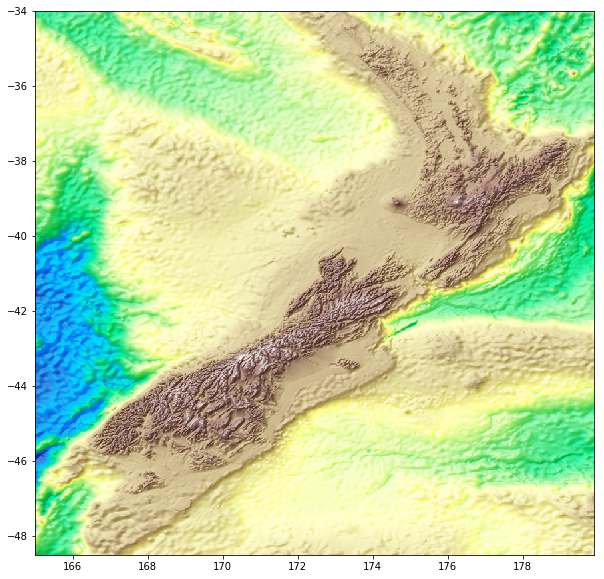

In [36]:
fig = plt.figure(1, figsize=(14,10))
ax = fig.add_subplot(111, xlim=(minX,maxX), ylim=(minY,maxY))
# ax.axis('off')
ls = LightSource(azdeg=315, altdeg=45)
rgb = ls.shade(LandImg, cmap=cm.terrain, blend_mode='soft', vert_exag=2., dx=50, dy=50)
im1 = ax.imshow(rgb, extent=[minX, maxX, minY, maxY], cmap=cm.terrain, origin='upper')
plt.show()

In [37]:
coords = np.stack((y1, x1)).T

im_coords = coords.copy()
im_coords[:,0] -= minY
im_coords[:,1] -= minX

im_coords[:,0] *= LandImg.shape[0] / (maxY-minY) 
im_coords[:,1] *= LandImg.shape[1] / (maxX-minX) 
im_coords[:,0] =  LandImg.shape[0] - im_coords[:,0]

In [38]:
from scipy import ndimage

meshheights = ndimage.map_coordinates(LandImg, im_coords.T, order=3, mode='nearest').astype(np.float)

# Fake geoid for this particular region
# meshheights -= 40.0 * (y1 - minY) / (maxY - minY)

In [39]:
## Filter out the points we don't want at all 

points = meshheights > -50 

m1s = meshheights[points]
x1s = x1[points]
y1s = y1[points]

submarine = m1s < 0.0
subaerial = m1s >= 0.0

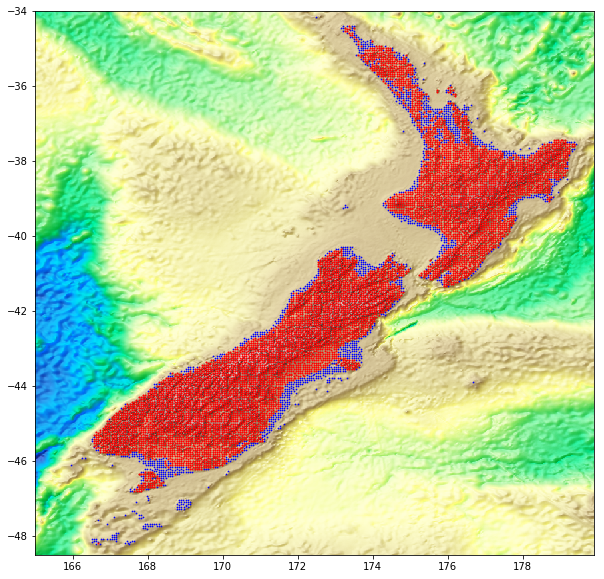

In [40]:
fig = plt.figure(1, figsize=(14,10))
ax = fig.add_subplot(111, xlim=(minX,maxX), ylim=(minY,maxY))
# ax.axis('off')

ls = LightSource(azdeg=315, altdeg=45)
rgb = ls.shade(LandImg, cmap=cm.terrain, blend_mode='soft', vert_exag=2., dx=50, dy=50)
im1 = ax.imshow(rgb, extent=[minX, maxX, minY, maxY], cmap=cm.terrain, origin='upper')
ax.scatter(x1s[submarine], y1s[submarine], s=0.5, color="Blue")
ax.scatter(x1s[subaerial], y1s[subaerial], s=1.0, color="Red")

plt.show()

### 3. Create the DM

The points are now read into a DM and refined so that we can achieve very high resolutions. Refinement is achieved by adding midpoints along line segments connecting each point.

In [75]:
DM = meshtools.create_DMPlex_from_points(x1s, y1s, submarine, refinement_steps=4)

In [76]:
mesh = quagmire.SurfaceProcessMesh(DM, verbose=True)

0 - Delaunay triangulation 5.09178s
0 - Calculate node weights and area 0.120617s
0 - Find boundaries 0.029847s
0 - cKDTree 0.558759s
0 - Construct neighbour cloud array 13.438912s
0 - Construct rbf weights 4.892846s


In [77]:
x2r = mesh.tri.x
y2r = mesh.tri.y
simplices = mesh.tri.simplices
bmaskr = mesh.bmask

In [78]:
## Now re-do the allocation of points to the surface.
## In parallel this will be done process by process for a sub-set of points

coords = np.stack((y2r, x2r)).T

im_coords = coords.copy()
im_coords[:,0] -= minY
im_coords[:,1] -= minX

im_coords[:,0] *= LandImg.shape[0] / (maxY-minY) 
im_coords[:,1] *= LandImg.shape[1] / (maxX-minX) 
im_coords[:,0] =  LandImg.shape[0] - im_coords[:,0]

In [79]:
from scipy import ndimage

spacing = 1.0
coords = np.stack((y2r, x2r)).T / spacing

meshheights = ndimage.map_coordinates(LandImg, im_coords.T, order=3, mode='nearest')
meshheights = mesh.rbf_smoother(meshheights, iterations=2)

# meshheights -= 40.0 * (y2r - minY) / (maxY - minY)

In [80]:
subaerial =  meshheights >= 0.0
submarine = ~subaerial
mesh.bmask = subaerial

In [81]:
## Fake geoid. This should perhaps be a struct on the surface mesh as it is not an actual height change !


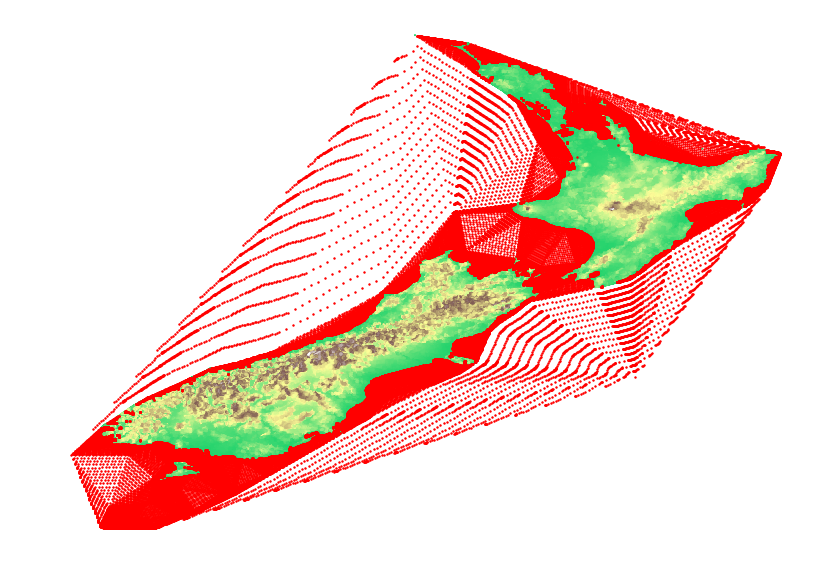

In [82]:
fig = plt.figure(1, figsize=(14, 10))
ax = fig.add_subplot(111)
ax.axis('off')

sc = ax.scatter(x2r[subaerial], y2r[subaerial], s=1.0, c=meshheights[subaerial], cmap=cm.terrain, vmin=-1000.0, vmax=2500)
sc = ax.scatter(x2r[submarine], y2r[submarine], s=2.0, c="Red", alpha=1.0)
# sc = ax.scatter(x2r[hmask], y2r[hmask], s=0.5, c="Blue")


#fig.colorbar(sc, ax=ax, label='height')
plt.show()

In [83]:
# for i in range(0, 10):
#     meshheights = mesh.handle_low_points(0.0, 20)
#     mesh.update_height(meshheights)
#     low_points = mesh.identify_low_points()
#     print low_points.shape[0]
  
# m v km !

mesh.update_height(meshheights*0.001)
mesh.handle_low_points(its=20)

0 - Compute slopes 5.786363s
0 - Build downhill matrices 3.418361s
000/0 no of low points - 3101 
 - Partial rebuild of downhill matrices 1.400643s
001/0 no of low points - 2855 
 - Partial rebuild of downhill matrices 1.272374s
002/0 no of low points - 2764 
 - Partial rebuild of downhill matrices 1.289223s
003/0 no of low points - 2613 
 - Partial rebuild of downhill matrices 1.294383s
004/0 no of low points - 2539 
 - Partial rebuild of downhill matrices 1.258741s
005/0 no of low points - 2465 
 - Partial rebuild of downhill matrices 1.324028s
006/0 no of low points - 2433 
 - Partial rebuild of downhill matrices 1.289242s
007/0 no of low points - 2367 
 - Partial rebuild of downhill matrices 1.268309s
008/0 no of low points - 2281 
 - Partial rebuild of downhill matrices 1.262413s
009/0 no of low points - 2197 
 - Partial rebuild of downhill matrices 1.226056s
010/0 no of low points - 2153 
 - Partial rebuild of downhill matrices 1.256873s
011/0 no of low points - 2073 
 - Partial 

array([-0.00244825,  0.82788043,  0.74604397, ..., -0.02053428,
       -0.02289214, -0.02237367])

In [84]:
flowpaths = mesh.cumulative_flow(np.ones_like(mesh.height))
flowpaths2 = mesh.rbf_smoother(flowpaths, iterations=1)

DHmat**2
DHmat**2 - done 


In [86]:
manifold = np.reshape(mesh.coords[mesh.bmask], (-1,2))
manifold = np.insert(manifold, 2, values=mesh.height[mesh.bmask]*0.25, axis=1)

In [87]:
from LavaVu import lavavu

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

topo = lv.points(pointsize=2.0, pointtype=0)
topo.vertices(manifold)
topo.values(mesh.height[mesh.bmask], label='height')
# topo.values(np.sqrt(flowpaths), label='flow')

topo2 = lv.points(pointsize=2.0, pointtype=0)
topo2.vertices(manifold+(0.0,0.0,0.1))
# topo.values(mesh.height, label='height')
topo2.values(np.sqrt(flowpaths2[mesh.bmask]), label='flow')


# topo3 = lv.points(pointsize=2.0, pointtype=0)
# topo3.vertices(manifold+(0.0,0.0,0.1))
# # topo.values(mesh.height, label='height')
# topo3.values(np.sqrt(flowpathsG2[bmaskr]), label='flowG')


topo.colourmap(["#004420", "#FFFFFF", "#444444"] , logscale=False, range=[-0.2, 1.0])   # Apply a built in colourmap
# topo.colourmap(["#FFFFFF:0.0", "#0033FF:0.3", "#000033"], logscale=False)   # Apply a built in colourmap
topo2.colourmap(["#FFFFFF:0.0", "#0033FF:0.1", "#000033"], logscale=True)   # Apply a built in colourmap

# topo3.colourmap(["#FFFFFF:0.0", "#0033FF:0.1", "#000033"], logscale=True)   # Apply a built in colourmap



1

In [88]:
lv.window()

# tris.control.Range(property='zmin', range=(-1,1), step=0.001)
# lv.control.Range(command='background', range=(0,1), step=0.1, value=1)
# lv.control.Range(property='near', range=[-10,10], step=2.0)
lv.control.Checkbox(property='axis')
lv.control.Command()
lv.control.ObjectList()
lv.control.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 5. Save to HDF5

Save the mesh to an HDF5 file so that it can be visualised in Paraview or read into Quagmire another time. There are two ways to do this:

1. Using the `save_DM_to_hdf5` function in meshtools, or
2. Directly from trimesh interface using `save_mesh_to_hdf5` method.

Remember to execute `petsc_gen_xdmf.py austopo.h5` to create the XML file structure necessary to visualise the mesh in paraview.

In [85]:
filename = 'NZTopo.h5'

mesh.save_mesh_to_hdf5(filename)
mesh.save_field_to_hdf5(filename, height=mesh.height, 
                                  slope=mesh.slope, flow=np.sqrt(flowpaths2))

# to view in Paraview
meshtools.generate_xdmf(filename)